QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread (0x3aa6a50).
Cannot move to target thread (0x32476c0)

QObject::moveToThread: Current thread (0x32476c0) is not the object's thread

Latency of each classification is:  0.00336109739069249
Acc: 0.888889, Recall: 0.880662, Precision: 0.994100, F1: 0.933949 


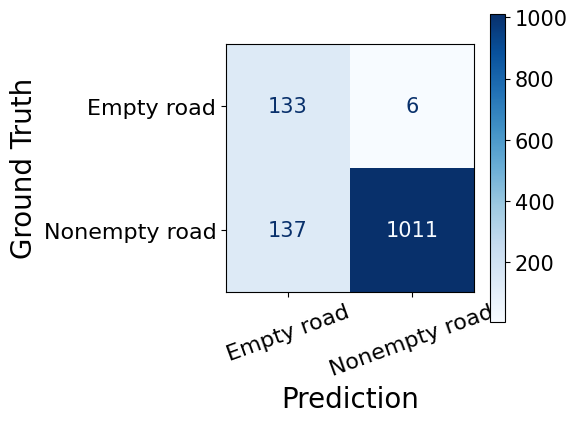

In [3]:
# classification with background subtraction, data extract from video
'''
pickup total 6428 instances, 1287 is test's
put erd extracted images under:
 - /home/royliu/Documents/datasets/traffic/empty_road_pure_test
 - /home/royliu/Documents/datasets/traffic/nonempty_road_pure_test
 
 or anywhere else but change the path name in 'data_table_pure_test_all.csv' accordingly
'''
import pandas as pd
import os
import cv2
import numpy as np
import math
import time

data_table = pd.read_csv('../data_table_pure_test_all.csv', index_col=0)
data_table = data_table.reset_index(drop= True) # rest index in order
data_table = data_table.iloc[:1287,:] ## make the testing dataset length as the same as erd's
data_table.img_path = data_table.img_path.str.replace('/home/royliu/Documents/dataset/traffic/', '/home/royliu/Documents/datasets/traffic/')
img_path_list, label_list = data_table.iloc[:,0], data_table.iloc[:,1]  # column 0 is image path, column 1 is label
size = (500,400)
mask_500x400 =  cv2.imread('./mask_500x400.png')
pred_list = []
pred_list.append(1)

def psnr(img):
    img1=img
    img2=np.zeros(img.shape)  #用 np.empty会出错
    mse = np.mean((img1 / 1.0 - img2 / 1.0) ** 2)
    # compute psnr
    if mse < 1e-10:
        return 100
    psnr = 20 * np.log10(255 / math.sqrt(mse))
    return psnr

def mse(img):
    img1=img
    img2=np.zeros(img.shape) #用 np.empty会出错
    return np.mean((img1 / 1.0 - img2 / 1.0) ** 2)

i=0
lastFrame = None
latency = []
for file_path in img_path_list:
    start = time.time()
    frame = cv2.imread(file_path)
    frame = cv2.resize(frame, (500, 400), interpolation=cv2.INTER_CUBIC)  # 调整该帧的大小
    frame = mask_500x400 * frame
    if lastFrame is None:
        lastFrame = frame
        continue

    frameDelta = cv2.absdiff(lastFrame, frame)  # compute difference btween 2 frames
    lastFrame = frame.copy()  # set it as the next frame
    thresh = cv2.cvtColor(frameDelta, cv2.COLOR_BGR2GRAY)  # tuun to gray
    thresh = cv2.threshold(thresh, 25, 255, cv2.THRESH_BINARY)[1]  # turn to binary
    cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # interate contours
    for c in cnts:
        # ingnore small contours
        if cv2.contourArea(c) < 500:
            continue

        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    if i % 15 == 0:
        PSNR = psnr(thresh)
        MSE = mse(thresh)
        #         print(thresh)
        img = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)

    pred_list.append(1) if MSE >= 100 else pred_list.append(0)
    
    latency.append(time.time()-start)
    word_x, word_y = 20, 40
    cv2.putText(frame, 'PSNR: %f' % PSNR, (word_x, word_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, 'MSE: %f' % MSE, (word_x, word_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
    i += 1
    cv2.imshow("frame", frame)
    cv2.imshow("frameDelta", frameDelta)
    cv2.imshow("thresh", thresh)

    key = cv2.waitKey(1) & 0xFF  # or, waitKey(int(1000/fps_video))
    if key == 27:  # 27: ESC to quite ， q: ord('q')
        break

cv2.destroyAllWindows()
print('Latency of each classification is: ', np.mean(latency))

#plotting
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt 

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20, fontsize=16)
    plt.yticks( fontsize=16)
    ax.set_xlabel('Prediction',fontsize=20);ax.set_ylabel('Ground Truth',fontsize=20)
    plt.rcParams.update({'font.size': 15}) ## change the font size in matrix
    plt.show()
    plot_dir = '../result/' 
#     cm.figure_.savefig(plot_dir+'confusion_matrix_bkgd.pdf',bbox_inches='tight')

classes = ['Empty road', 'Nonempty road']
print('Acc: %f, Recall: %f, Precision: %F, F1: %f '% (accuracy_score(label_list, pred_list),\
    recall_score(label_list, pred_list), precision_score(label_list, pred_list), f1_score(label_list, pred_list)))
plot_confusion_matrix(label_list, pred_list, classes)